# Relax Data Science Challenge

### Problem Statement
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

### Implementation
Firstly, import all the relevant libraries and read datasets into Pandas dataframes.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

In [0]:
df1 = pd.read_csv('takehome_users.csv', parse_dates=True, encoding = "latin-1")
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [0]:
df2 = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [0]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


After some exploration we can see there are null values in the "last session creation time" and "invited by user id" fields.

In [0]:
df1.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

To remove null values in "invited by user id" field, fill in null values with 0 indicated no user invited them.
Zeros will also be used to to remove null values in "last session creation time" field.

In [0]:
df1[['invited_by_user_id', 'last_session_creation_time']] = df1[['invited_by_user_id', 'last_session_creation_time']].fillna(value=0)
df1.isna().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [0]:
df2.isna().sum()
#no null values here

time_stamp    0
user_id       0
visited       0
dtype: int64

Rename the "object_id" column to "user_id" to match with other dataset.
Convert 'last_session_creation_time' to the datetime format.

In [0]:
df1.rename(columns = {'object_id':'user_id'}, inplace = True)
df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'],unit='s')
df1.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


Let's look at the possible values of "creation_source" and use LabelEncoder to encode those values.

In [0]:
df1.creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [0]:
le = LabelEncoder() #Encode it
df1['creation_source'] = le.fit_transform(df1['creation_source'])

In [0]:
df1.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,2013-01-22 10:14:20,0,0,193,5240.0


In [0]:
df2['time_stamp']= pd.to_datetime(df2['time_stamp']) #convert time_stamp to datetime format

Create a dataframe where rows are grouped by user_id and 7 day periods and sum how many times a user has visited in that 7 day period.

In [0]:
a_df2 = df2.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7D')])['visited'].sum().reset_index()

We're interested in the users who visit 3 or more times in each 7-day period - these will be our adopted users.

In [0]:
adopted2 = a_df2.loc[a_df2['visited'] > 2]
adopted2.head(5)

,user_id,time_stamp,visited
22,10,2013-02-14,3
24,10,2013-02-28,3
26,10,2013-03-14,3
29,10,2013-04-11,4
31,10,2013-04-25,4


Assign all the users from the previous table as adopted users. We will join this table with our users dataframe (df1). After joining the 2 dataframes, null values in the adopted_user column will be filled with 0, indicating a user who is not described as adopted.

In [0]:
users = pd.DataFrame({'user_id': adopted2.user_id.unique(), 'adopted_user': 1})
users.head()

,user_id,adopted_user
0,10,1
1,42,1
2,43,1
3,53,1
4,63,1


In [0]:
users.info() #1445 adopted users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 2 columns):
user_id         1445 non-null int64
adopted_user    1445 non-null int64
dtypes: int64(2)
memory usage: 22.7 KB


In [0]:
#join the users table with the adopted users table
df_merged = pd.merge(left=df1,right=users, how='left', left_on='user_id', right_on='user_id')
df_merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,2014-04-22 03:53:30,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-31 03:45:04,0,0,1,316.0,NaN
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 23:14:52,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,2013-05-22 08:09:28,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,2013-01-22 10:14:20,0,0,193,5240.0,NaN


In [0]:
#fill in the null values with 0 for non-adopted users
df_merged['adopted_user'] = df_merged['adopted_user'].fillna(value=0)
df_merged.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-31 03:45:04,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,2013-01-22 10:14:20,0,0,193,5240.0,0.0


Now let's visualize the data. Firstly, we'll look at adopted users every month.

In [0]:
df_merged['creation_time'] = pd.to_datetime(df_merged['creation_time'])
grouped = df_merged.groupby([pd.Grouper(key='creation_time', freq='1M')])['adopted_user'].sum().reset_index()
grouped.head()

,creation_time,adopted_user
0,2012-05-31,1.0
1,2012-06-30,62.0
2,2012-07-31,56.0
3,2012-08-31,62.0
4,2012-09-30,64.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


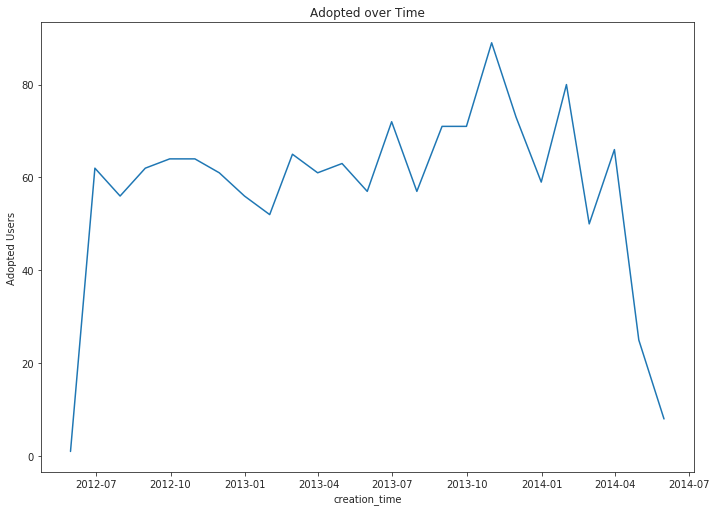

In [0]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.lineplot(x='creation_time', y = 'adopted_user', data=grouped, ax=ax)
plt.ylabel('Adopted Users')
plt.title('Adopted over Time');

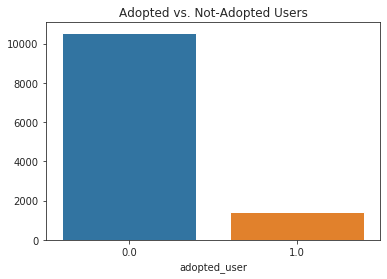

In [0]:
sns.countplot(x='adopted_user', data=df_merged)
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

Taking a look at the ratio of adopted users vs not adopted users, we can see our data is unbalanced. Some data upsampling is needed.

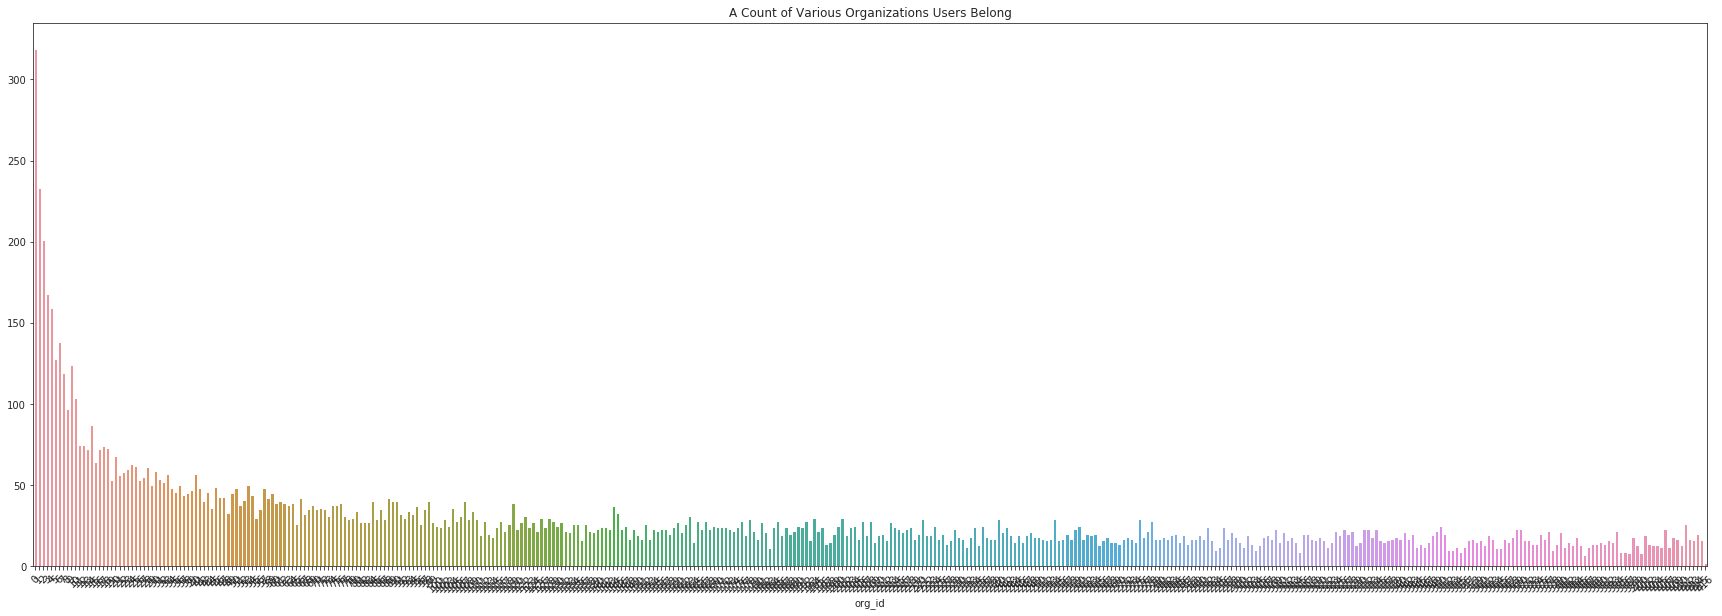

In [0]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

chart = sns.countplot(x='org_id', data=df_merged, ax=ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.ylabel('')
plt.title('A Count of Various Organizations Users Belong');

In [0]:
df_majority = df_merged[df_merged.adopted_user==0]
df_minority = df_merged[df_merged.adopted_user==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=10555, random_state=42)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.adopted_user.value_counts()

1.0    10555
0.0    10555
Name: adopted_user, dtype: int64

Now that our data is more balanced, let's prepare the data for the ML model. Firstly, all unneccesary and non-numeric columns like "user_id" "name" and "email", etc. will be dropped from the dataframe. All the date columns are dropped also.

In [0]:
df_upsampled = df_upsampled.drop(['user_id','name','email','creation_time','last_session_creation_time'], axis=1)

In the "invited_by_user" column, it doesn't matter which user invited them, just whether a user invited them or not. This column will be encoded with just 0 or 1.

In [0]:
df_upsampled['invited_by_user_id'] = df_upsampled['invited_by_user_id'].apply(lambda x: 1 if x!=0 else 0)

In [0]:
df_upsampled.tail(20)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
5949,4,0,0,175,0,1.0
4008,2,1,0,62,0,1.0
571,3,1,1,35,0,1.0
4868,0,1,0,270,1,1.0
11729,0,0,0,69,1,1.0
4618,0,1,1,3,1,1.0
11956,3,0,0,413,0,1.0
3955,1,0,0,9,1,1.0
4942,3,0,0,2,0,1.0
8382,0,0,0,159,1,1.0


Now, training data and labels are assigned and data is split into training and test sets.

In [0]:
X = df_upsampled.drop(['adopted_user'], axis=1)
Y = df_upsampled['adopted_user']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

For this model, RandomForestClassifier is selected. A GridSearch will be done to determine the best parameters to give the best model performance.

In [0]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [0]:
param_grid = { 
    'n_estimators': [100, 150, 175, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini','entropy']
}
rfcv = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
rfcv.fit(X_train, y_train)
print (rfcv.best_params_)

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 175}


Now that the best parameters have been determined, let's look at our model's performance with a confusion matrix and a classification report.

In [0]:
y_pred = rfcv.predict(X_test)
print(confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[2260  954]
 [ 380 2739]]
Accuracy: 78.94%


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77      3214
         1.0       0.74      0.88      0.80      3119

    accuracy                           0.79      6333
   macro avg       0.80      0.79      0.79      6333
weighted avg       0.80      0.79      0.79      6333



Since the problem statement was to identify which factors predict future user adoption, feature importances are extracted from the model.

In [0]:
for name, importance in zip(df_upsampled.columns, rfcv.best_estimator_.feature_importances_):
  print(name, "=", importance)

creation_source = 0.03353332476325274
opted_in_to_mailing_list = 0.009572876478389307
enabled_for_marketing_drip = 0.009391620216012067
org_id = 0.9438000565518673
invited_by_user_id = 0.00370212199047856


From the last cell, the feature that most affected predictions was the organization id, the factor most likely to determine if a user becomes an adopted user is to which organization a user belongs.